# Accessing data later, after the measurement

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Get the data from previous *run(s)* and work with it.

## Skip the `instrument` package

There is no need to import the instrument package since we won't measure anything in this notebook.

## Access the database

In the instrument package (in file `instrument/framework/initialize.py`), we connected databroker with the MongoDB server using the `class_2021_03` *catalog*. Get that catalog now.  We'll need to import some tools first.

In [1]:
from apstools.utils import listruns, quantify_md_key_use
import databroker
from databroker.queries import TimeRange

db = databroker.catalog["class_2021_03"]
listruns()

catalog name: class_2021_03
========= ========================== ======= ======= ========================================
short_uid date/time                  exit    scan_id command                                 
========= ========================== ======= ======= ========================================
dff821e   2021-02-24 19:55:30.877637 success 42809   count(detectors=['temperature'], num=50)
54623bd   2021-02-24 19:55:10.010586 success 42808   count(detectors=['temperature'], num=10)
bd1b5a0   2021-02-24 19:55:07.992559 success 42807   count(detectors=['temperature'], num=10)
188b6b4   2021-02-24 19:55:07.421838 success 42806   count(detectors=['temperature'], num=1) 
ea64830   2021-02-24 19:54:38.117091 success 42805   count(detectors=['temperature'], num=1) 
========= ========================== ======= ======= ========================================



Our temperature count measurement is one of those listed, but which one?  Recall how we started our run: `RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))`.  

In case some other type of run is more recent, we'll search for the most recent run with this metadata.  First, find any recent (since Feb 2021) runs with this metadata.  We need to do this search with the `v2` version of databroker catalogs.  The result of the search is another catalog.

In [2]:
cat = db.v2.search(TimeRange(since="2021-02-02")).search({"motive": "tscan"})
print(f"Search for runs with motive='tscan' metadata found {len(cat)} run(s).")

Search for runs with motive='tscan' metadata found 1 run(s).


Show the run's metadata.

In [3]:
if len(cat):
    run = cat[-1]
else:
    raise KeyError("No runs found with `motive='tscan'`")

run.metadata

{'start': Start({'beamline_id': 'APS_Python_training_2021',
 'detectors': ['temperature'],
 'hints': {'dimensions': [[['time'], 'primary']]},
 'instrument_name': 'class_2021_03',
 'login_id': 'jemian@otz.xray.aps.anl.gov',
 'motive': 'tscan',
 'num_intervals': 49,
 'num_points': 50,
 'pid': 12191,
 'plan_args': {'detectors': ["MyPvPositioner(prefix='gp:userCalc8', "
                             "name='temperature', settle_time=0.0, "
                             "timeout=None, read_attrs=['setpoint', "
                             "'readback', 'done', 'calculation', "
                             "'description', 'max_change', 'noise', "
                             "'previous_value_pv', 'scanning_rate', "
                             "'tolerance'], configuration_attrs=[], "
                             "limits=(-20, 255), egu='C')"],
               'num': 50},
 'plan_name': 'count',
 'plan_type': 'generator',
 'proposal_id': 'training',
 'scan_id': 42809,
 'time': 1614218130.8776371,
 

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [4]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [5]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [6]:
import pyRestTable

table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ==================
measure value             
======= ==================
max     25.472167544060426
mean    25.03523949034867 
dev     0.2544483983769354
min     24.54193179217212 
#       50                
======= ==================



Let's replot that data for comparison.

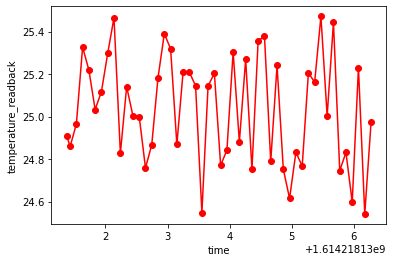

In [7]:
dataset["temperature_readback"].plot(marker="o", color="red")